In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings
import joblib

# Load the dataset
file_path = "/Users/alonclausen/Desktop/Studie/Kandidat/Seminar/SEMINARFIN/fulldata.csv"
data = pd.read_csv(file_path)



In [30]:
# Ensure the 'from' column is in datetime format and set it as index
data['from'] = pd.to_datetime(data['from'])
data = data.set_index('from')
data.index = pd.DatetimeIndex(data.index.values, freq=pd.infer_freq(data.index))

# Training data: from August 1, 2023, to August 1, 2024
train_start_date = '2023-08-01'
train_end_date = '2024-08-01'
train_data = data[(data.index >= train_start_date) & (data.index <= train_end_date)]
spot_price_train = train_data['SpotPriceDKK']

In [31]:
# Fit the SARIMA model (ARIMA(2,0,0)(2,0,1)[24] with intercept)
warnings.filterwarnings("ignore")  # Ignore warnings for cleaner output
sarima_model = SARIMAX(spot_price_train, order=(2, 0, 0), seasonal_order=(2, 0, 1, 24), trend='c')
sarima_results = sarima_model.fit(disp=False)

RMSE: 317.0535119042118


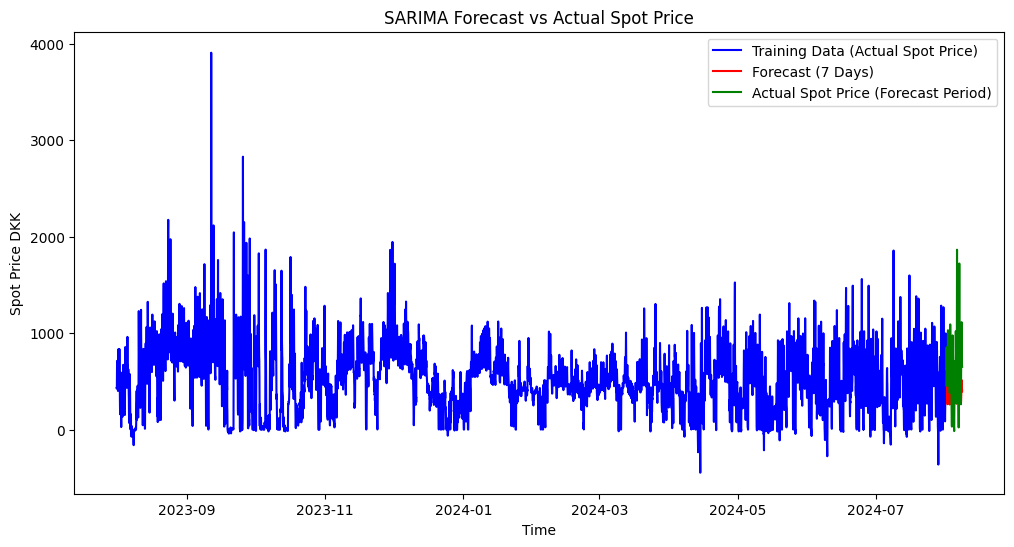

In [32]:
# Forecast for the next 7 days (168 hours) after the training end date
forecast_steps = 168
forecast_start = pd.Timestamp(train_end_date) + pd.Timedelta(hours=1)
forecast_index = pd.date_range(start=forecast_start, periods=forecast_steps, freq='H')

forecast = sarima_results.get_forecast(steps=forecast_steps).predicted_mean
forecast.index = forecast_index

# Extract actual values for the forecast period if available
actual_start_date = forecast_start
actual_end_date = forecast_index[-1]
actual_values = data[(data.index >= actual_start_date) & (data.index <= actual_end_date)]

# Calculate RMSE if actual values are available
if not actual_values.empty:
    actual_spot_price = actual_values['SpotPriceDKK']
    rmse = np.sqrt(mean_squared_error(actual_spot_price, forecast))
    print(f"RMSE: {rmse}")

# Plot the training data, forecast, and actual values
plt.figure(figsize=(12, 6))
plt.plot(spot_price_train, label='Training Data (Actual Spot Price)', color='blue')
plt.plot(forecast, label='Forecast (7 Days)', color='red')
if not actual_values.empty:
    plt.plot(actual_spot_price, label='Actual Spot Price (Forecast Period)', color='green')
plt.xlabel('Time')
plt.ylabel('Spot Price DKK')
plt.title('SARIMA Forecast vs Actual Spot Price')
plt.legend()
plt.show()

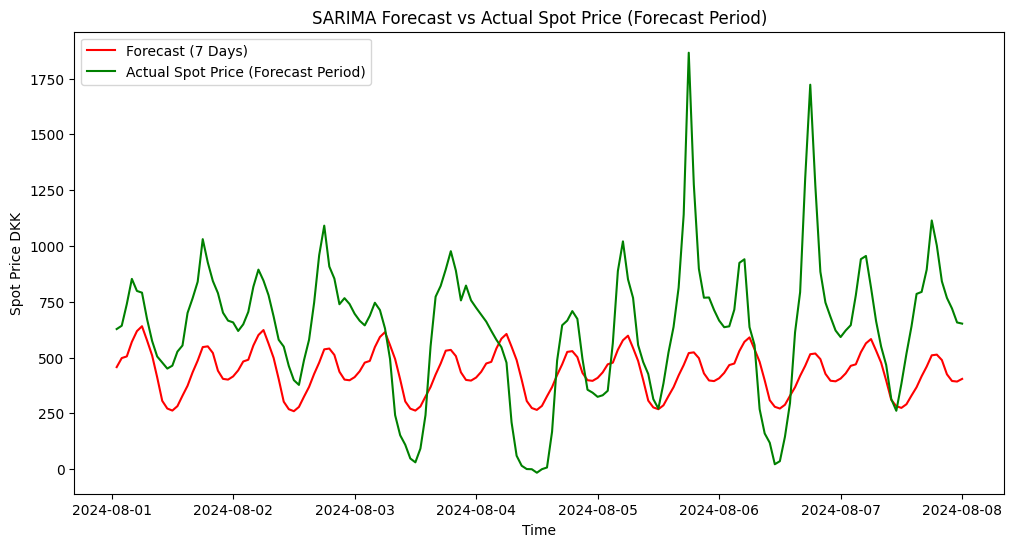

In [33]:
# Plot the forecast and actual values for the forecast period
plt.figure(figsize=(12, 6))
plt.plot(forecast, label='Forecast (7 Days)', color='red')
if not actual_values.empty:
    plt.plot(actual_spot_price, label='Actual Spot Price (Forecast Period)', color='green')
plt.xlabel('Time')
plt.ylabel('Spot Price DKK')
plt.title('SARIMA Forecast vs Actual Spot Price (Forecast Period)')
plt.legend()
plt.show()